# Motor Imagery in ECoG Recordings, session-to-session transfer

In [1]:

import mne
from mne.io import RawArray
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper


import numpy as np
from numpy import genfromtxt

import pylab as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA

PATH = '/Users/lin/Desktop/BCICompetitionIII/DatasetI/'
TEST_PATH = '/Users/lin/Desktop/BCICompetitionIII/DatasetI/Competition_test.mat'
TRAIN_PATH = '/Users/lin/Desktop/BCICompetitionIII/DatasetI/Competition_train.mat'
SAMPLE_FREQ = 1000


## Import the data

> * The time series of the electrical brain activity was picked up during these trials using a 8x8 ECoG platinum electrode grid which was placed on the contralateral (right) motor cortex.
> * All recordings were performed with a sampling rate of 1000Hz. 
> * After amplification the recorded potentials were stored as microvolt values.
> * Every trial consisted of either an imagined tongue or an imagined finger movement and was recorded for 3 seconds duration.
> * Format: [trials, electrode channels, samples of time series]
> * After amplification the recorded potentials were stored as microvolt values

In [2]:
mat_test = loadmat(TEST_PATH)
print("Variable mat_test contains:")
print(mat_test.keys())

test = np.array(mat_test['X'])
print("\nDimension of testing dataset:")
print(test.shape)

print("\n\n")

mat_train = loadmat(TRAIN_PATH)
print("Variable mat_train contains:")
print(mat_train.keys())

train = np.array(mat_train['X'])
label = np.array(mat_train['Y'])
print("\nDimension of training dataset:")
print(train.shape)
print("\nDimension of label set:")
print(label.shape)



trial_num = train.shape[0]
chan_num = train.shape[1]
sample_num = train.shape[2]
print("\n\n")
print("Training set has " + str(chan_num) + " channels.")
print("Training set has " + str(trial_num) + " trials.")
print("Each recording has " + str(sample_num) + " samples")


Variable mat_test contains:
dict_keys(['__header__', '__version__', '__globals__', 'X'])

Dimension of testing dataset:
(100, 64, 3000)



Variable mat_train contains:
dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y'])

Dimension of training dataset:
(278, 64, 3000)

Dimension of label set:
(278, 1)



Training set has 64 channels.
Training set has 278 trials.
Each recording has 3000 samples


In [3]:
%%capture
raw = [None] * trial_num

info = mne.create_info(ch_names = chan_num,
                       sfreq = SAMPLE_FREQ,
                       ch_types = 'ecog')

for x in range(trial_num):
    raw[x] = RawArray(train[x], info)

### Display a sample of ECoG and its power spectral density

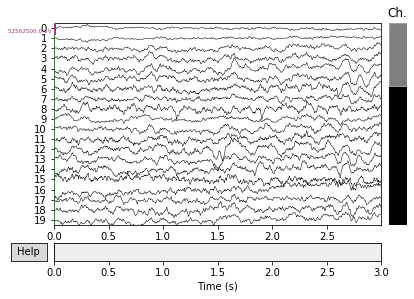

Effective window size : 2.048 (s)


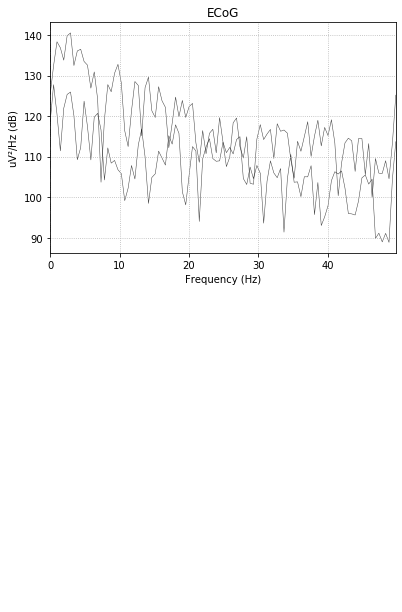

In [4]:
raw[0].plot(scalings = 'auto');
raw[0].plot_psd(fmax = 50, picks = [0,12], spatial_colors = False);

## Architecture of the algorithm
<img src = "img/archi.png" width=600>


## Preprocessing
* ICA features 
<br> <img src = 'img/ICA.png' width = 1000> <br>
* AAR features
* CSP features
* Time-freq features


### ICA  
ICA finds the independent sources that compose the original singal.
<br>
* Not sure if I should create one ICA for all signals or one ICA for each trial.
* current approach is to train one for all, have not finished yet
* an issue here: ICA not converge

In [11]:
%%capture

ica = ICA(n_components = 15, random_state = 7)
ica_comp = [None] * trial_num
ica_var = [None] * trial_num


for x in range(trial_num):
    ica.fit(raw[x])
    ica_comp[x] = ica.get_sources(raw[x])
    ica_var[x] = ica.pca_explained_variance_

ica_var = np.array(ica_var)


### Display two samples of ICA and the variances explained

First 20 ICA components of the first trial:
<RawArray  |  None, n_channels x n_times : 15 x 3000 (3.0 sec), ~385 kB, data loaded>


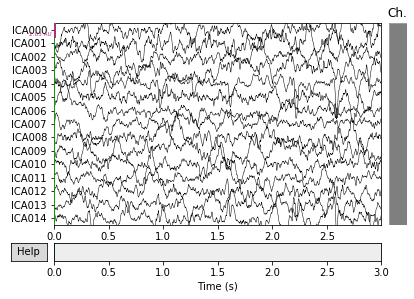



First 20 ICA components of the second trial:
<RawArray  |  None, n_channels x n_times : 15 x 3000 (3.0 sec), ~385 kB, data loaded>


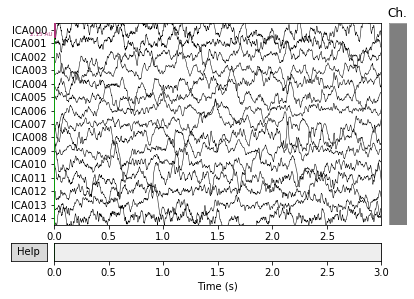

In [12]:
print("First 20 ICA components of the first trial:")
print(ica_comp[0])
ica_comp[0].plot(scalings = 'auto');
print("\n\nFirst 20 ICA components of the second trial:")
print(ica_comp[1])
ica_comp[1].plot(scalings = 'auto');

In [13]:
var_score = [0.0] * trial_num

for i in range(ica_var.shape[0]):
    for j in range(ica_var.shape[1]):
        var_score[i] += ica_var[i, j]

print(np.round(var_score, decimals = 3))
print('\n')
print(np.round(ica_var[0], decimals = 2))
print('\n')
print(np.round(ica_var[1], decimals = 3))
print('\n')

[40.035 34.801 43.982 34.696 36.394 31.543 30.569 15.759 37.719 34.483
 37.589 33.28  39.27  35.433 31.062 42.326 33.249 41.782 45.057 37.957
 35.039 10.844 33.146 34.101 43.686 38.509 43.02  41.073 34.414 34.059
 39.44  46.325 32.973 22.831 29.034 43.955 34.138 29.446 33.528 32.109
 16.926 34.152 41.21  33.264 16.463 37.44  16.608 26.34  34.548 40.001
 38.364  5.233 15.716 36.305 38.14  43.047 42.385 42.886 33.131 42.031
 12.32  35.006 39.279 28.799 37.348 42.544 42.776 42.839 34.111 42.359
 36.066  7.993 27.381 37.303 41.322 19.421 50.048 24.04  42.623 39.377
 38.102 39.946 37.293 38.434 39.172 28.392 40.579 39.731 33.122 20.831
 41.816 34.375 23.943 37.006 33.568 38.947 31.512 37.8   39.681 40.109
 44.816 41.863 44.577 36.047 40.067 40.19  35.47  41.359 28.798 35.265
 43.43  43.023 35.859 32.975 30.783 40.886 28.782 35.936 33.774 35.534
 24.716 37.18  35.997 38.195 36.134 13.652 30.373 38.663 35.656 34.548
 29.578 35.734 29.863 37.016 41.309 35.219 40.238 39.401 36.68  31.968
 41.92

Text(0.5, 1.0, 'The variance explained for each ICA component from trial 1 and 2 ')

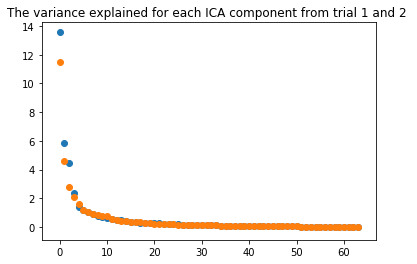

In [14]:
fig, arr = plt.subplots()
arr.scatter(range(ica_var[0].shape[0]), ica_var[0])
arr.scatter(range(ica_var[1].shape[0]), ica_var[1])
arr.set_title('The variance explained for each ICA component from trial 1 and 2 ')

### Time-frequency
Transform the signals to time-frequency domain by the Multitaper transform method<br>
Steps:
1. Create events 

In [5]:
epoch_time = .6 #int(sample_num / 10) / SAMPLE_FREQ
tmin = 0
tmax = epoch_time - 0.01

events = mne.make_fixed_length_events(raw[0], duration = epoch_time)
print(events)

[[   0    0    1]
 [ 600    0    1]
 [1200    0    1]
 [1800    0    1]
 [2400    0    1]]


2. Divide the signals into epochs and display a sample of epoch

In [6]:
%%capture

epochs = [None] * trial_num

for x in range(trial_num):
    epochs[x] = mne.Epochs(raw[x], events = events,
                           tmin = tmin, tmax = tmax,
                           baseline = None)

<Epochs  |   5 events (good & bad), 0 - 0.59 sec, baseline off, ~125 kB, data not loaded,
 '1': 5>
Loading data for 5 events and 591 original time points ...
0 bad epochs dropped
Loading data for 5 events and 591 original time points ...
Loading data for 5 events and 591 original time points ...


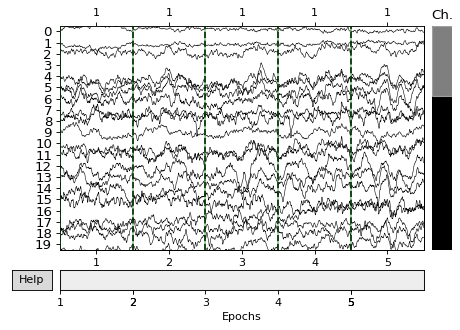

In [7]:
print(epochs[0])
epochs[0].plot(scalings = 'auto');

3. Multitaper transformation and display time-frequency representation

In [10]:
#vmin, vmax = -3., 3.  # Define our color limits.
tfr_freqs = np.arange(4., 50., 2.)
n_cycles = SAMPLE_FREQ / 2
power = [None] * trial_num


for x in range(trial_num):
    print(x)
    power[x] = tfr_multitaper(epochs[x], return_itc = False, 
                           freqs = tfr_freqs, n_cycles = n_cycles)

0
Loading data for 10 events and 291 original time points ...


ValueError: At least one of the wavelets is longer than the signal. Use a longer signal or shorter wavelets.

The error occured because the time-window has to be smaller than the legnth of its epoch. time-window = n_cycles / freq. <br>
However when n_cycles is freq divided by 2, the time-window is 0.5, which is larger than 0.3. A smaller is n_cycles is required. 

### Solution for the issue

In [8]:
tfr_freqs = np.arange(2., 15., 1)
n_cycles = tfr_freqs / 5

print("The time-windows for each frequencies are")
print(n_cycles / tfr_freqs)
print(", which are all less than " + str(epoch_time))

The time-windows for each frequencies are
[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
, which are all less than 0.6


In [22]:
%%capture

power = [None] * trial_num
for x in range(trial_num):
    print("Now transforming trial " + str(x))
    power[x] = tfr_multitaper(epochs[x], return_itc = False, 
                           freqs = tfr_freqs, n_cycles = n_cycles)

Save the time-frequency representation

In [26]:
power =  np.array(power)
tmp = [None] * power.shape[0]

for x in range(power.shape[0]):
    tmp[x] = power[x].data
power = np.array(tmp)
power.shape

(278, 64, 13, 591)

In [28]:
np.save(PATH + "power", power)

Plot an example

Applying baseline correction (mode: mean)


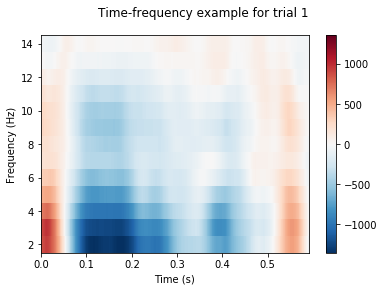

In [11]:
power[0].plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

Loading data for 5 events and 591 original time points ...
Applying baseline correction (mode: mean)


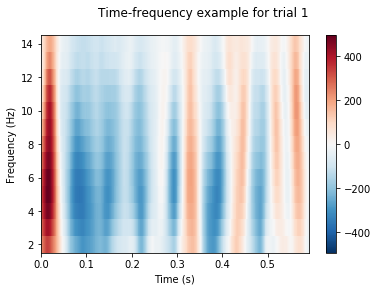

Loading data for 5 events and 591 original time points ...
Applying baseline correction (mode: mean)


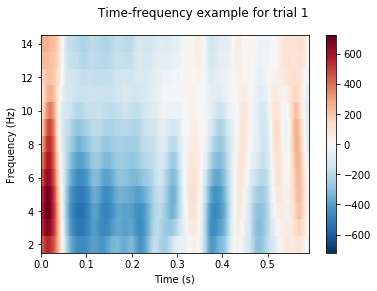

Loading data for 5 events and 591 original time points ...
Applying baseline correction (mode: mean)


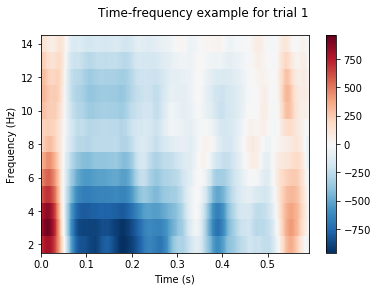

Loading data for 5 events and 591 original time points ...
Applying baseline correction (mode: mean)


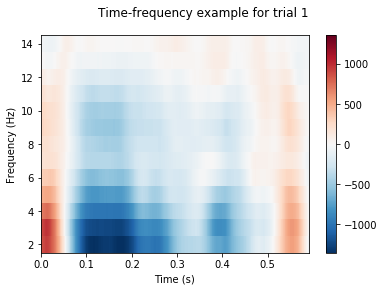

Loading data for 5 events and 591 original time points ...
Applying baseline correction (mode: mean)


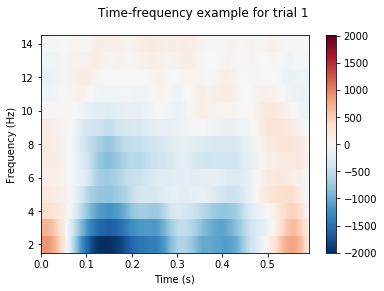

Loading data for 5 events and 591 original time points ...
Applying baseline correction (mode: mean)


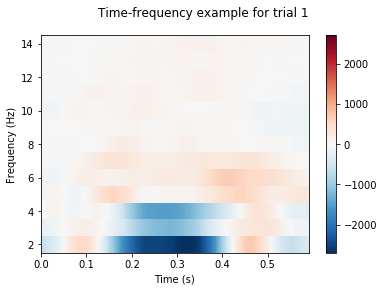

In [99]:
n_cycles_ = tfr_freqs / 10
cyc_test = tfr_multitaper(epochs[0], return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

n_cycles_ = tfr_freqs / 8
cyc_test = tfr_multitaper(epochs[0], return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

n_cycles_ = tfr_freqs / 6
cyc_test = tfr_multitaper(epochs[0], return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');


n_cycles_ = tfr_freqs / 5
cyc_test = tfr_multitaper(epochs[0], return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

n_cycles_ = tfr_freqs / 4
cyc_test = tfr_multitaper(epochs[0], return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

n_cycles_ = tfr_freqs / 2
cyc_test = tfr_multitaper(epochs[0], return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');


10 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 10 events and 591 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)


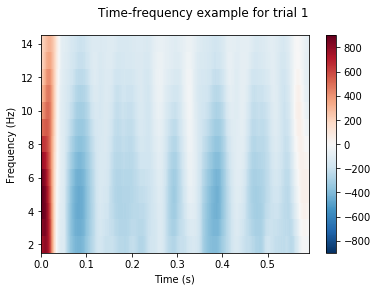

Loading data for 9 events and 591 original time points ...
Applying baseline correction (mode: mean)


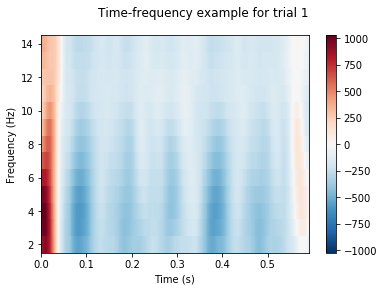

Loading data for 9 events and 591 original time points ...
Applying baseline correction (mode: mean)


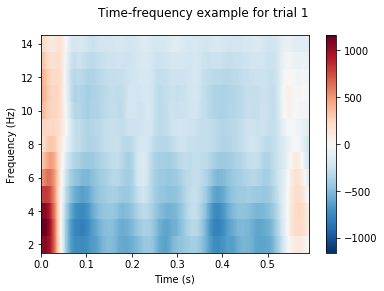

Loading data for 9 events and 591 original time points ...
Applying baseline correction (mode: mean)


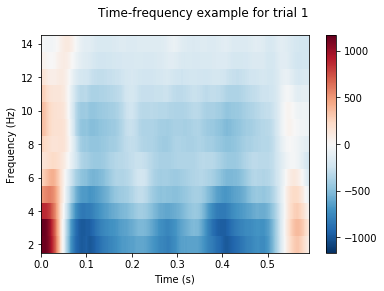

Loading data for 9 events and 591 original time points ...
Applying baseline correction (mode: mean)


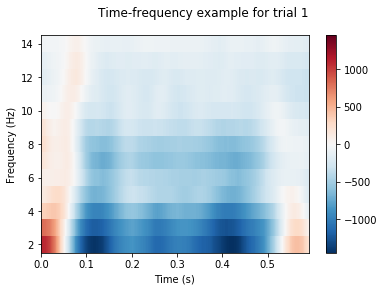

Loading data for 9 events and 591 original time points ...
Applying baseline correction (mode: mean)


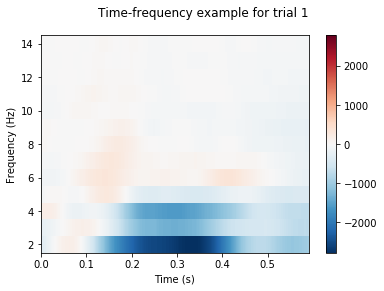

In [106]:
epoch_time_test = .3 #int(sample_num / 10) / SAMPLE_FREQ
events_test = mne.make_fixed_length_events(raw[0], duration = epoch_time_test)

epochs_test = mne.Epochs(raw[0], events = events_test, tmin = tmin, 
                         tmax = tmax, baseline = None)

n_cycles_ = tfr_freqs / 10
cyc_test = tfr_multitaper(epochs_test, return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

n_cycles_ = tfr_freqs / 8
cyc_test = tfr_multitaper(epochs_test, return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

n_cycles_ = tfr_freqs / 6
cyc_test = tfr_multitaper(epochs_test, return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');


n_cycles_ = tfr_freqs / 5
cyc_test = tfr_multitaper(epochs_test, return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

n_cycles_ = tfr_freqs / 4
cyc_test = tfr_multitaper(epochs_test, return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

n_cycles_ = tfr_freqs / 2
cyc_test = tfr_multitaper(epochs_test, return_itc = False,
                          freqs = tfr_freqs, n_cycles = n_cycles_)
cyc_test.plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example for trial 1');

### AAR

### CSP

## Feature Selection
Try the features extracted above, and find a set of feature that gives the highest accuracy for Support Vector Machine. This step is only for supervised learning. The feature selection precess would not be involved in the semi-supervised session
* Raw data fed into SVM
* ICA feature fed into SVM
* Time-frequency fed into SVM

Note: features are calculated from predetermined algorithms, such as ICA or Fourier Decomp, so there is no adaptation process. After selecting the best feature for SVM, the feature then can be dynamically adapted for each trial. 



### Spilt the dataset into testing and training set

In [102]:
X_train, X_test, Y_train, Y_test = train_test_split(train, label, 
                                                    test_size=0.1,
                                                    random_state = 7)
# convert labels to a vector
Y_train = Y_train[:, 0]
Y_test = Y_test[:, 0]

n_train_trials = X_train.shape[0]
n_test_trials = X_test.shape[0]

print("Dimension of X_train:", X_train.shape)
print("Dimension of Y_train:", Y_train.shape)
print("\nDimension of X_test:", X_test.shape)
print("Dimension of Y_test:", Y_test.shape)

Dimension of X_train: (250, 64, 3000)
Dimension of Y_train: (250,)

Dimension of X_test: (28, 64, 3000)
Dimension of Y_test: (28,)


### Train SVMs on raw data
Each SVM is trained different time segment.

Divide the 3 seconds signal into 6 segments.
Dimension for each sample: 500.0


Now training SVM on time segment from 0 to 500
Accuracy: 0.6428571428571429
Now training SVM on time segment from 500 to 1000
Accuracy: 0.7142857142857143
Now training SVM on time segment from 1000 to 1500
Accuracy: 0.8214285714285714
Now training SVM on time segment from 1500 to 2000
Accuracy: 0.7857142857142857
Now training SVM on time segment from 2000 to 2500
Accuracy: 0.6428571428571429
Now training SVM on time segment from 2500 to 3000
Accuracy: 0.75


Text(0.5, 1.0, 'Accuracy of SVM at certain time period')

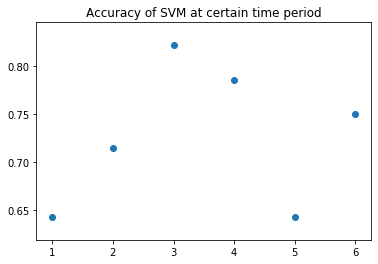

In [104]:
time_segments = 6
n_features = sample_num/time_segments

print("Divide the 3 seconds signal into " + str(time_segments) + " segments.")
print("Dimension for each sample: " + str(n_features))
print("\n")

fig, arr = plt.subplots()

# initialization of x-y axis of time-accuracy graph
accuracy = np.zeros(time_segments)
xaxis = np.zeros(time_segments)

# separate test/training dataset(optional)
#X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.1)

for x in range(time_segments):
    # select the hyperparameter: time period, for each iteration
    i = int(x * n_features)
    f = int((x + 1) * n_features)
    print("Now training SVM on time segment from " + str(i) + " to " + str(f))
    
    segment_train = X_train[:, :, i : f].reshape((n_train_trials, int(chan_num * n_features)))
    segment_test = X_test[:, :, i : f].reshape((n_test_trials, int(chan_num * n_features)))
    
    # calculate SVM with different hyperparameters
    clf_AAR = svm.SVC(kernel = 'linear', C = 100).fit(segment_train, Y_train)
    
    # store the accuracy and print on the terminal
    accuracy[x] = clf_AAR.score(segment_test, Y_test)
    xaxis[x] = x + 1
    
    print("Accuracy: " + str(accuracy[x]))

# rendering Accuracy of SVM at certain time period
arr.scatter(xaxis, accuracy)
arr.set_title('Accuracy of SVM at certain time period')

In [110]:
%%capture
# initialization of x-y axis of time-accuracy graph
runs = 30
run_acc = np.zeros((runs, time_segments))

for t in range(runs):
    for x in range(time_segments):
        
        X_train, X_test, Y_train, Y_test = train_test_split(train, label, 
                                                    test_size=0.1)
        Y_train = Y_train[:, 0]
        Y_test = Y_test[:, 0]
        
        # select the hyperparameter: time period, for each iteration
        i = int(x * n_features)
        f = int((x + 1) * n_features)
        print("Now training SVM on time segment from " + str(i) + " to " + str(f))
    
        segment_train = X_train[:, :, i : f].reshape((n_train_trials, int(chan_num * n_features)))
        segment_test = X_test[:, :, i : f].reshape((n_test_trials, int(chan_num * n_features)))
        
        # calculate SVM with different hyperparameters
        clf_AAR = svm.SVC(kernel = 'linear', C = 100).fit(segment_train, Y_train)
        
        # store the accuracy and print on the terminal
        run_acc[t,x] = clf_AAR.score(segment_test, Y_test)

np.save(PATH + 'run_acc', run_acc)

takes about 9 minutes to run the whole thing, so store the run_acc to a file 

(30, 6)


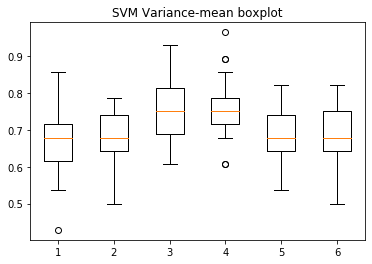

In [124]:
print(run_acc.shape)

f, ax = plt.subplots(1,1)
ax.set_title('SVM Variance-mean boxplot')
ax.boxplot(run_acc);

### Train SVMs on ICA features
The hyperparameters would be the n_components and n_segnments. The logic behind this is that ICA reduces the redundant features, the dimentsion of the data space becomes smaller -- Remedy curse of dimensionality <br><br> ica_comp[] stores the first 15 ICA components, and the Index indicates the trial 

In [25]:
# convert the ica components to a numpy array 
ica_train = [None] * trial_num
for x in range(trial_num):
    ica_train[x], dicard = ica_comp[x][:]
    
ica_train = np.array(ica_train)
print("The dimension of the training set is " + str(ica_train.shape))

The dimension of the training set is (278, 15, 3000)


In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(ica_train, label, 
                                                    test_size=0.1,
                                                    random_state = 2)
# convert labels to a vector
Y_train = Y_train[:, 0]
Y_test = Y_test[:, 0]

n_train_trials = X_train.shape[0]
n_test_trials = X_test.shape[0]

print("Dimension of X_train:", X_train.shape)
print("Dimension of Y_train:", Y_train.shape)
print("\nDimension of X_test:", X_test.shape)
print("Dimension of Y_test:", Y_test.shape)

Dimension of X_train: (250, 15, 3000)
Dimension of Y_train: (250,)

Dimension of X_test: (28, 15, 3000)
Dimension of Y_test: (28,)


Divide the 3 seconds signal into 6 segments.
Dimension for each sample: 500.0


Now training SVM on time segment from 0 to 500
Accuracy: 0.5
Now training SVM on time segment from 500 to 1000
Accuracy: 0.6071428571428571
Now training SVM on time segment from 1000 to 1500
Accuracy: 0.35714285714285715
Now training SVM on time segment from 1500 to 2000
Accuracy: 0.4642857142857143
Now training SVM on time segment from 2000 to 2500
Accuracy: 0.5714285714285714
Now training SVM on time segment from 2500 to 3000
Accuracy: 0.5714285714285714


Text(0.5, 1.0, 'Accuracy of SVM at certain time period')

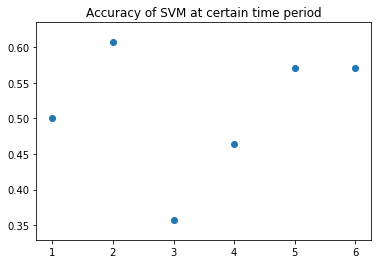

In [30]:
time_segments = 6
n_features = sample_num/time_segments
ica_num = ica_train.shape[1]

print("Divide the 3 seconds signal into " + str(time_segments) + " segments.")
print("Dimension for each sample: " + str(n_features))
print("\n")

fig, arr = plt.subplots()

# initialization of x-y axis of time-accuracy graph
accuracy = np.zeros(time_segments)
xaxis = np.zeros(time_segments)


for x in range(time_segments):
    # select the hyperparameter: time period, for each iteration
    i = int(x * n_features)
    f = int((x + 1) * n_features)
    print("Now training SVM on time segment from " + str(i) + " to " + str(f))
    
    segment_train = X_train[:, :, i : f].reshape((n_train_trials, int(ica_num * n_features)))
    segment_test = X_test[:, :, i : f].reshape((n_test_trials, int(ica_num * n_features)))
    
    # calculate SVM with different hyperparameters
    clf_AAR = svm.SVC(kernel = 'linear', C = 100).fit(segment_train, Y_train)
    
    # store the accuracy and print on the terminal
    accuracy[x] = clf_AAR.score(segment_test, Y_test)
    xaxis[x] = x + 1
    
    print("Accuracy: " + str(accuracy[x]))

# rendering Accuracy of SVM at certain time period
arr.scatter(xaxis, accuracy)
arr.set_title('Accuracy of SVM at certain time period')

In [15]:

#tmp = X_train.reshape((n_train_trials, X_train.shape[1] * X_train.shape[2] ))

#clf_AAR = svm.SVC(kernel = 'linear', C = 100).fit(tmp, Y_train)

#tmp_accuracy = clf_AAR.score(X_test.reshape((n_test_trials, X_test.shape[1] * X_test.shape[2] )), Y_test)

#print("Accuracy: " + str(tmp_accuracy))

### Train SVMs on time-frequency representations

In [29]:

print("The dimension of the training set is " + str(power.shape))

The dimension of the training set is (278, 64, 13, 591)


In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(power, label, 
                                                    test_size=0.1,
                                                    random_state = 2)
# convert labels to a vector
Y_train = Y_train[:, 0]
Y_test = Y_test[:, 0]

n_train_trials = X_train.shape[0]
n_test_trials = X_test.shape[0]

print("Dimension of X_train:", X_train.shape)
print("Dimension of Y_train:", Y_train.shape)
print("\nDimension of X_test:", X_test.shape)
print("Dimension of Y_test:", Y_test.shape)


Dimension of X_train: (250, 64, 13, 591)
Dimension of Y_train: (250,)

Dimension of X_test: (28, 64, 13, 591)
Dimension of Y_test: (28,)


In [32]:
time_segments = 6
frq_range = power.shape[2]
sample_num = power.shape[3]
n_features = int(sample_num/time_segments)

print("Divide the 3 seconds signal into " + str(time_segments) + " segments.")
print("Dimension for each sample: " + str(n_features))
print("\n")

Divide the 3 seconds signal into 6 segments.
Dimension for each sample: 98




Now training SVM on time segment from 0 to 98
Accuracy: 0.7142857142857143
Now training SVM on time segment from 98 to 196
Accuracy: 0.8214285714285714
Now training SVM on time segment from 196 to 294
Accuracy: 0.7857142857142857
Now training SVM on time segment from 294 to 392
Accuracy: 0.6071428571428571
Now training SVM on time segment from 392 to 490
Accuracy: 0.75
Now training SVM on time segment from 490 to 588
Accuracy: 0.8214285714285714


Text(0.5, 1.0, 'Accuracy of SVM at certain time period')

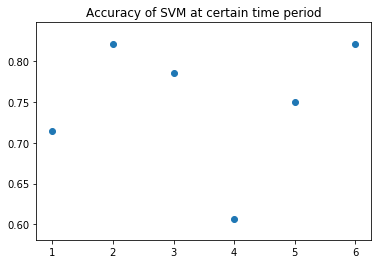

In [34]:

fig, arr = plt.subplots()

# initialization of x-y axis of time-accuracy graph
accuracy = np.zeros(time_segments)
xaxis = np.zeros(time_segments)


for x in range(time_segments):
    # select the hyperparameter: time period, for each iteration
    i = int(x * n_features)
    f = int((x + 1) * n_features)
    print("Now training SVM on time segment from " + str(i) + " to " + str(f))
    
    segment_train = X_train[:, :, :, i : f].reshape((n_train_trials, int(frq_range * chan_num * n_features)))
    segment_test = X_test[:, :, :, i : f].reshape((n_test_trials, int(frq_range * chan_num * n_features)))
    
    # calculate SVM with different hyperparameters
    clf_AAR = svm.SVC(kernel = 'linear', C = 100).fit(segment_train, Y_train)
    
    # store the accuracy and print on the terminal
    accuracy[x] = clf_AAR.score(segment_test, Y_test)
    xaxis[x] = x + 1
    
    print("Accuracy: " + str(accuracy[x]))

# rendering Accuracy of SVM at certain time period
arr.scatter(xaxis, accuracy)
arr.set_title('Accuracy of SVM at certain time period')

## Domain Adaptation

## Semi-supervised (fake) online adaptation